In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from scipy.interpolate import RegularGridInterpolator as rgi

In [2]:
Pwave = np.loadtxt("PwaveSolution")
Swave = np.loadtxt("SwaveSolution")
iasp  = np.loadtxt("iasp.txt");
opxdT = np.loadtxt("gt_temp.txt")
d = Pwave[:,3] <= 200. # depth used in the current model
# ltd = Pwave[d,1] # latitude
depth = Pwave[d,3]  
delta_vp = Pwave[d,2]
delta_vs = Swave[d,2]
# reference velocity model
Vp_o = np.ones(len(depth)); 
Vs_o = np.ones(len(depth)) 
dVp = np.ones(len(depth));
dVs = np.ones(len(depth));
print(len(np.unique(depth)) )

9


In [3]:
print (np.unique(depth))

[  5.  10.  20.  40.  80. 100. 120. 160. 200.]


In [4]:
for i in range (len(depth)):
    Vp_o[i]  = (iasp[:,1][iasp[:,0] <= depth[i]].max())*1.e3 # find P wave reference velocity for the tomography
    Vs_o[i]  = (iasp[:,2][iasp[:,0] <= depth[i]].max())*1.e3 # find P wave reference velocity for the tomography
    dVp[i]   = delta_vp[i] * Vp_o[i]/100;
    dVs[i]   = delta_vs[i] * Vs_o[i]/100
    
X  = np.unique(Pwave[:,0])
Y  = np.flipud(-1*np.unique(Pwave[:,1])) # in descending order
Z  = np.unique(depth) # multiply by -1 according to tomography

# reshape matrices for plotting depth slices
opx = np.reshape(opxdT[:,0], (9, 20, 26))
dT  = np.reshape(opxdT[:,1], (9, 20, 26))
dvp = np.reshape(dVp, (9, 20, 26)) ; 
dvs = np.reshape(dVs, (9, 20, 26))

In [4]:
#***** CHANGED FOR LAB PROJECT , DEPTH is NOW 300 km
Vs1 = dVs + Vs_o ; Vp1 = dVp + Vp_o
Vs_new = np.reshape(Vs1, (11, 20, 26)); Vp_new = np.reshape(Vp1, (11, 20, 26));
# arrange columns for meshgrid, strictly ascending
fn = rgi((Z, Y, X), dvs, bounds_error=False, fill_value=None)
fn1 = rgi((Z, Y, X), dvp, bounds_error=False, fill_value=None)
xp    = 888.00 ; yp = -777.00 # point of NMSZ used for plotting in km
pol   = np.column_stack((Z, yp*np.ones(len(Z)), xp*np.ones(len(Z)))) #plot over line
plot_over_line_Vs = (fn(pol)); 
plot_over_line_Vp = (fn1(pol));
np.savetxt('vel_model.txt', np.column_stack( ( Z, plot_over_line_Vp/1.e3, plot_over_line_Vs/1.e3 )))

ValueError: cannot reshape array of size 4680 into shape (11,20,26)

In [5]:
# define interpolation function
fn = rgi((Z, Y, X), opx, bounds_error=False, fill_value=None)
# define query points for interpolation
Xq  = np.linspace(min(Pwave[:,0]), max(Pwave[:,0]), 100)
Yq  = np.linspace(-max(Pwave[:,1]), -min(Pwave[:,1]), 95) # Y assumed negative for ascending order
Zq  = np.linspace(0, 200, 40)
(grid_y, grid_z, grid_x) = np.meshgrid(Yq, Zq, Xq)
points_x = np.reshape(grid_x, (380000, 1))
points_y = np.reshape(grid_y, (380000, 1))
points_z = np.reshape(grid_z, (380000, 1))
query = np.column_stack((points_z, points_y, points_x)) # everything tested on small data-set
Interp_x = fn(query) 
fn1 = rgi((Z, Y, X), dvp, bounds_error=False, fill_value=None)
Interp_vp = fn1(query)
fn2 = rgi((Z, Y, X), dvs, bounds_error=False, fill_value=None)
Interp_vs = fn2(query)
fn3 = rgi((Z, Y, X), dT, bounds_error=False, fill_value=None)
Interp_dT = fn3(query)

In [6]:
Opx_reshap = np.reshape(Interp_x, (380000, 1))
Vp_reshap  = np.reshape(Interp_vp, (380000, 1))
dT_reshap  = np.reshape(Interp_dT, (380000, 1))
Vs_reshap  = np.reshape(Interp_vs, (380000, 1))

dT = np.ones((40, 95, 100))
delvp = np.ones((40, 95, 100))
delvs = np.ones((40, 95, 100))
X_opx = np.ones((40, 95, 100))

for j in range (len ( Zq )): 
    Xi = np.reshape( points_x[points_z == Zq[j]] , (95, 100)) # number of lat = 20 , long = 26 
    Yi = np.reshape( points_y[points_z == Zq[j]] , (95, 100))
    X_opx[j,:,:] = np.reshape( Opx_reshap[points_z == Zq[j]], (95, 100))
    delvp[j,:,:] = np.reshape( Vp_reshap[points_z == Zq[j]] , (95, 100))
    dT[j,:,:]    = np.reshape( dT_reshap[points_z == Zq[j]] , (95, 100))
    delvs[j,:,:] = np.reshape( Vs_reshap[points_z == Zq[j]] , (95, 100))

num = 31# depth 

In [7]:
print(np.amax(dT[16,:,:]))

544.1796502014622


Text(0.5,0,'$\\Delta$ T in K')

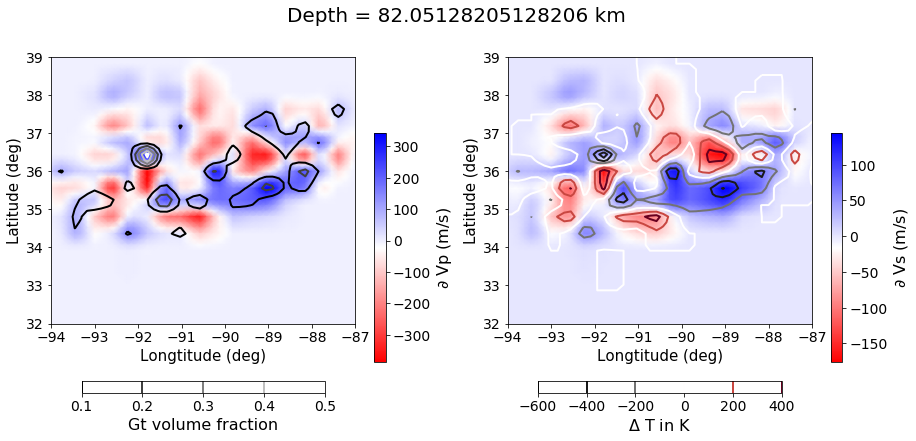

In [9]:
num = 16# depth 
plt.rcParams.update({'font.size': 14})
figure,  (ax1, ax2) = plt.subplots(1, 2,  figsize=(15, 7)) 
CS = ax1.pcolormesh(Xi, -Yi, delvp[num,:,:], cmap=cm.bwr_r, shading='gouraud')
CS.axes.set_ylabel('Latitude (deg)', fontsize=15)
CS.axes.set_xlabel('Longtitude (deg)', fontsize=15)
CS3 = ax2.pcolormesh(Xi, -Yi, delvs[num,:,:], cmap=cm.bwr_r, shading='gouraud')
plt.suptitle('Depth = %s km' %(Zq[num]),fontsize=20)
CS.axes.set_xlim([-94, -87])
CS.axes.set_ylim([32, 39])
CS3.axes.set_xlim([-94, -87])
CS3.axes.set_ylim([32, 39])
CS3.axes.set_ylabel('Latitude (deg)', fontsize=15)
CS3.axes.set_xlabel('Longtitude (deg)', fontsize=15)


CS1 = ax1.contour(Xi, -Yi, X_opx[num,:,:], 5, origin='lower', cmap=cm.gray, linewidths=2)
CS4 = ax2.contour(Xi, -Yi, dT[num,:,:], 6, origin='lower', vmin=-300, vmax=300, cmap=cm.RdGy_r, linewidths=2)

cbar = plt.colorbar(CS, shrink=0.6, ax=ax1)
cbar.ax.set_ylabel('$\partial$ Vp (m/s)', fontsize=16)
cbar = plt.colorbar(CS1, orientation='horizontal', shrink=0.8, ax=ax1)
cbar.ax.set_xlabel('Gt volume fraction', fontsize=16)

cbar1 = plt.colorbar(CS3,shrink=0.6, ax=ax2)
cbar1.ax.set_ylabel('$\partial$ Vs (m/s)', fontsize=16)
cbar1 = plt.colorbar(CS4, orientation='horizontal', shrink=0.8, ax=ax2)
cbar1.ax.set_xlabel('$\Delta$ T in K', fontsize=16)

# plt.show()
# plt.savefig("figOpx_%s.eps" %(num),format="eps", pad_inches=0, dpi=500)

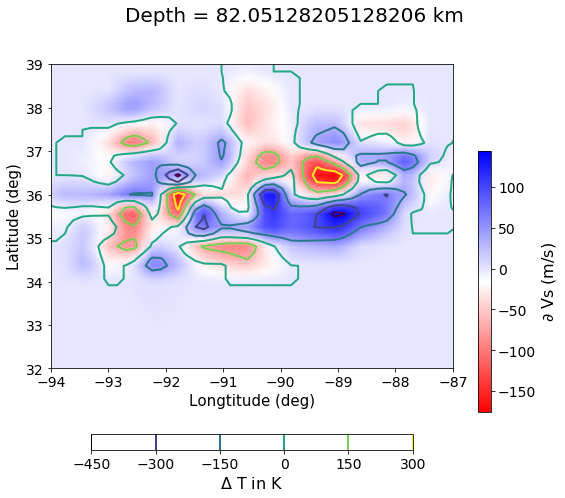

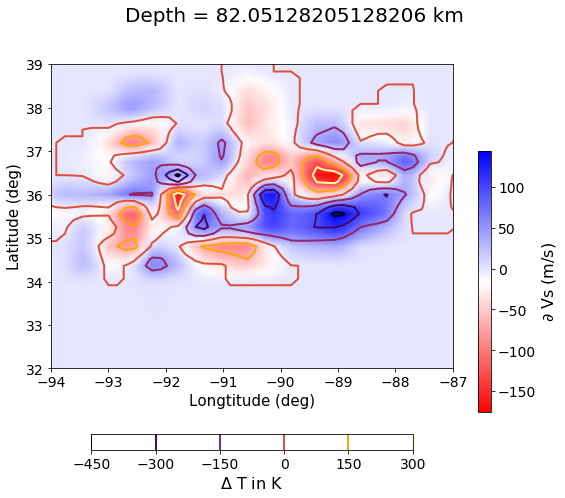

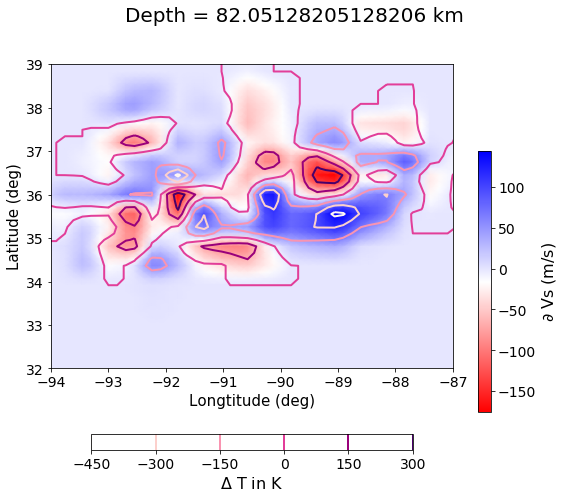

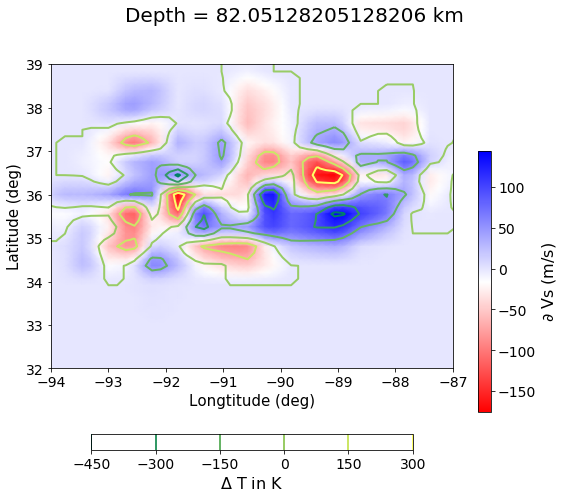

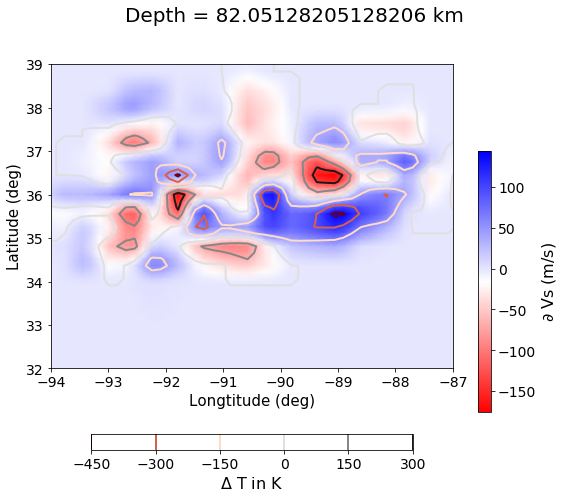

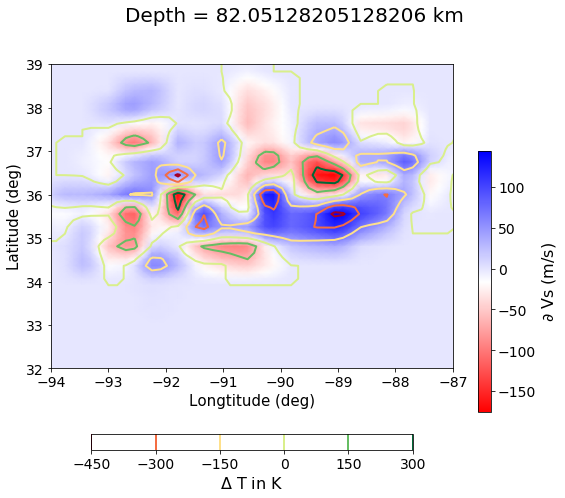

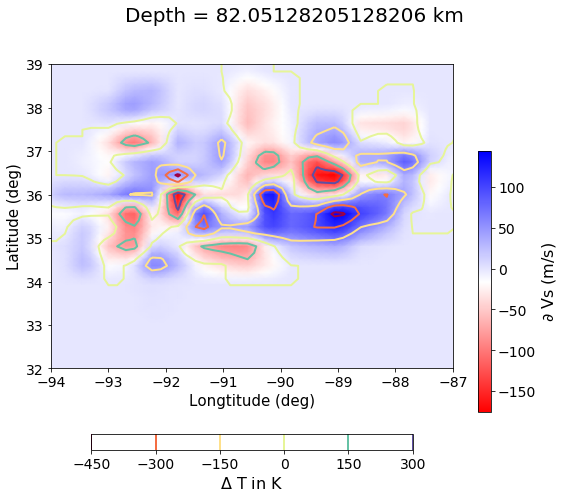

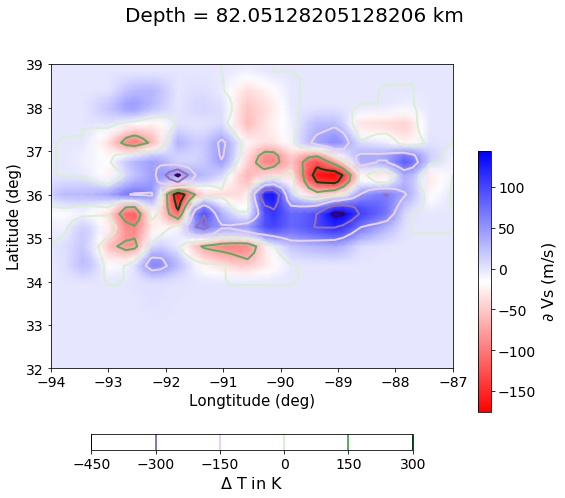

In [15]:
col_cont = ['viridis', 'inferno', 'RdPu', 'summer', 'RdGy', 'RdYlGn', 'Spectral', 'PRGn']

for i in range(len(col_cont)):
    figure,  (ax2) = plt.subplots(1, 1,  figsize=(9, 8)) 
    CS3 = ax2.pcolormesh(Xi, -Yi, delvs[num,:,:], cmap=cm.bwr_r, shading='gouraud')
    plt.suptitle('Depth = %s km' %(Zq[num]),fontsize=20)
    CS3.axes.set_xlim([-94, -87])
    CS3.axes.set_ylim([32, 39])
    CS3.axes.set_ylabel('Latitude (deg)', fontsize=15)
    CS3.axes.set_xlabel('Longtitude (deg)', fontsize=15)
    CS4 = ax2.contour(Xi, -Yi, dT[num,:,:], origin='lower', cmap=plt.get_cmap(col_cont[i]), linewidths=2)
    cbar1 = plt.colorbar(CS3,shrink=0.6, ax=ax2)
    cbar1.ax.set_ylabel('$\partial$ Vs (m/s)', fontsize=16)
    cbar1 = plt.colorbar(CS4, orientation='horizontal', shrink=0.8, ax=ax2)
    cbar1.ax.set_xlabel('$\Delta$ T in K', fontsize=16)
    plt.show()

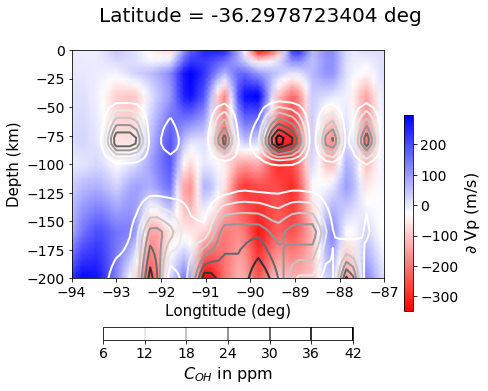

In [5]:
yo = Yq
num = 45 # latitude 
for k in range (len ( yo )): 
    X = np.reshape( points_x[points_y == yo[k]] , (40, 100)) # number of lat = 20 , long = 26 
    Z = np.reshape( points_z[points_y == yo[k]] , (40, 100))
    water[:,k,:] = np.reshape(Interp_reshap[points_y == yo[k]] , (40, 100))
    delvp[:,k,:] = np.reshape( Interpv_reshap[points_y == yo[k]] , (40, 100))  

plt.rcParams.update({'font.size': 14})
figure,  (ax2) = plt.subplots(1, 1,  figsize=(7, 6)) 
CS2 = ax2.pcolormesh(X, -Z, delvp[:,num,:], cmap=cm.bwr_r, shading='gouraud')
CS2.axes.set_ylabel('Depth (km)', fontsize=15)
CS2.axes.set_xlabel('Longtitude (deg)', fontsize=15)
plt.suptitle('Latitude = %s deg' %(yo[num]),fontsize=20)
CS2.axes.set_xlim([-94, -87])


CS4 = ax2.contour(X, -Z, water[:,num,:], origin='lower', cmap=cm.Greys, linewidths=2)

cbar1 = plt.colorbar(CS2, shrink=0.6, ax=ax2)
cbar1.ax.set_ylabel('$\partial$ Vp (m/s)', fontsize=16)
cbar1 = plt.colorbar(CS4, orientation='horizontal', shrink=0.8, ax=ax2)
cbar1.ax.set_xlabel('$C_{OH}$ in ppm', fontsize=16)

plt.show()
#plt.savefig("figOHd_%s.svg" %(yo[num]),format="svg", pad_inches=0, dpi=500)    